# Training with XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.

In [60]:
import os
import logging
import json

import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from data import DATA_DIR
from lama.util.decorators import enable_logging

logger = logging.getLogger()

OUT_DIR = os.path.join(DATA_DIR, "pre")
RESULT_DIR = os.path.join(DATA_DIR, "result")

In [61]:
train = pd.read_csv(os.path.join(OUT_DIR, "train_groupby.csv"))
test = pd.read_csv(os.path.join(OUT_DIR, "test_groupby.csv"))

features = train.columns.tolist()
features.remove("target")
features.remove("card_id")

In [62]:
# see <a href=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python />
param_init = {
    'objective': 'reg:linear',
    # analog to learning rate in gbm
    'eta': 0.3,
    # similar to min_child_leaf in GBM but not exactly.
    'min_child_weight': 0.8,
    # L2 regularization
    'lambda': 0.2,
    # L1 regularization
    'alpha': 0.5,
    'eval_metric': 'rmse',
    'seed': 2022,
    'early_stopping_rounds': 30,
    'num_boost_round': 1000,
    'verbose_eval': 50,
}


def dump(model, filename):
    with open(os.path.join(RESULT_DIR, filename), 'w') as file:
        model.dump_model(file, dump_format="json")


@enable_logging("perform_xgb_kfold.log")
def perform_xgb_kfold(train, test, features, target, params, n_split=5, random_state=22):
    kf = KFold(n_splits=n_split, random_state=random_state, shuffle=True)
    prediction_test = 0
    eval_results= {}
    predictions = np.zeros(train.shape[0])
    for i, (train_index, validation_index) in enumerate(kf.split(train[features])):
        train_xgb = xgb.DMatrix(train[features].loc[train_index].values,
                                train[target].loc[train_index].values)
        validation_xgb = xgb.DMatrix(train[features].loc[validation_index].values,
                                     train[target].loc[validation_index].values)

        bst: xgb.Booster  = xgb.train(params, train_xgb,
                        num_boost_round=params['num_boost_round'],
                        early_stopping_rounds=params['early_stopping_rounds'],
                        evals_result=eval_results,
                        evals=[(train_xgb, 'train'), (validation_xgb, 'eval')],
                        verbose_eval=params['verbose_eval'])
        logger.debug(f'evaluate results in round {i}: {eval_results}')

        prediction_test += bst.predict(xgb.DMatrix(test[features].values))
        validation_pre = bst.predict(validation_xgb)
        score = np.sqrt(mean_squared_error(train[target].loc[validation_index].values, validation_pre))
        logger.debug(f'CV Score in {i} round: {score}')

        predictions[validation_index] = validation_pre
        dump(bst, f'XGBoost_{i}.json')
    return prediction_test, predictions


In [63]:
n_split = 5
prediction_test, predictions = perform_xgb_kfold(train, test, features, 'target', param_init, n_split=n_split)


[17:52:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_round", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:1.71287	eval-rmse:1.72033
[50]	train-rmse:1.50487	eval-rmse:1.60746
[66]	train-rmse:1.48839	eval-rmse:1.60966
[17:55:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:08] WARNING: /Users/runner/m

In [67]:
test['target'] = prediction_test / n_split
test[['card_id', 'target']].to_csv(os.path.join(RESULT_DIR, "submission_xgboost_kfold.csv"), index=False)


prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_train.csv"))
prediction_csv['target_4'] = predictions
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_train.csv"), index=False)

prediction_csv = pd.read_csv(os.path.join(OUT_DIR, "prediction_test.csv"))
prediction_csv['target_4'] = prediction_test
prediction_csv.to_csv(os.path.join(OUT_DIR, "prediction_test.csv"), index=False)

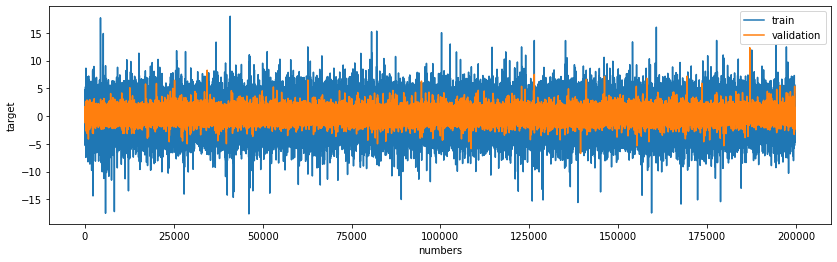

In [66]:
import matplotlib.pyplot as plt

def plot_train_validation(train, validation, target):
    plt.figure(figsize=(14,4))
    train_target = train[target]
    plt.plot(train_target, label='train')
    plt.plot(validation, label='validation')
    plt.xlabel("numbers")
    plt.ylabel(target)
    plt.legend()
    plt.show()
plot_train_validation(train, predictions, 'target')